# E2LSH マルチプローブ検証

## 目的

マルチプローブLSHを実装し、絞り込み性能が向上するかを検証する。

## マルチプローブとは

```
通常のE2LSH:
  クエリハッシュ: (4, -2, 16)
  → (4, -2, 16) のバケットのみ検索

マルチプローブ:
  クエリハッシュ: (4, -2, 16)
  → (4, -2, 16) に加えて
  → (4, -2, 15), (4, -2, 17)  ← 最後が±1
  → (4, -1, 16), (4, -3, 16)  ← 2番目が±1
  → (3, -2, 16), (5, -2, 16)  ← 最初が±1
  → なども探索
```

## 期待される効果

- wを小さくして「細かいバケット」を作成
- マルチプローブで隣接バケットも探索
- → より精密な絞り込みで、少ない候補数でも高いRecallを達成？

In [2]:
import sys
sys.path.insert(0, '..')

# モジュールをリロード（開発中）
import importlib
import src.e2lsh
importlib.reload(src.e2lsh)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.e2lsh import E2LSHHasher, E2LSHIndex, generate_multiprobe_keys

## 1. マルチプローブキー生成の確認

In [3]:
# マルチプローブキーの生成を確認
base_hash = (4, -2, 16)

print('=== マルチプローブキー生成 ===')
print(f'元のハッシュ: {base_hash}')

print('\n--- num_probes=1 (単一要素±1) ---')
keys_1 = generate_multiprobe_keys(base_hash, num_probes=1, max_perturbations=20)
for i, k in enumerate(keys_1):
    print(f'  {i}: {k}')
print(f'合計: {len(keys_1)}キー')

print('\n--- num_probes=2 (2要素まで±1) ---')
keys_2 = generate_multiprobe_keys(base_hash, num_probes=2, max_perturbations=50)
print(f'合計: {len(keys_2)}キー')
print('例:', keys_2[:10], '...')

=== マルチプローブキー生成 ===
元のハッシュ: (4, -2, 16)

--- num_probes=1 (単一要素±1) ---
  0: (4, -2, 16)
  1: (3, -2, 16)
  2: (5, -2, 16)
  3: (4, -3, 16)
  4: (4, -1, 16)
  5: (4, -2, 15)
  6: (4, -2, 17)
合計: 7キー

--- num_probes=2 (2要素まで±1) ---
合計: 19キー
例: [(4, -2, 16), (3, -2, 16), (5, -2, 16), (4, -3, 16), (4, -1, 16), (4, -2, 15), (4, -2, 17), (3, -3, 16), (3, -1, 16), (5, -3, 16)] ...


## 2. データ読み込み

In [4]:
# E5-largeのエンベディングを使用
df = pd.read_parquet('../data/embeddings_e5_large.parquet')
vectors = np.stack(df['vector'].values).astype(np.float32)
n_docs = len(vectors)
dim = vectors.shape[1]

print(f'ドキュメント数: {n_docs:,}')
print(f'次元数: {dim}')

# テストクエリ（100件）
np.random.seed(42)
query_indices = np.random.choice(n_docs, size=100, replace=False)
query_vectors = vectors[query_indices]
print(f'テストクエリ数: {len(query_vectors)}')

ドキュメント数: 10,000
次元数: 1024
テストクエリ数: 100


## 3. マルチプローブなし vs あり の比較

In [5]:
def evaluate_multiprobe(vectors, query_vectors, w, k, L, num_probes_list):
    """マルチプローブの効果を評価"""
    hasher = E2LSHHasher(dim=vectors.shape[1], w=w, k=k, num_tables=L, seed=42)
    index = E2LSHIndex(hasher)
    index.build(vectors)
    
    results = []
    
    for num_probes in num_probes_list:
        recalls = []
        candidate_counts = []
        
        for q_vec in query_vectors:
            # Ground Truth
            cos_sims = vectors @ q_vec
            top10 = set(np.argsort(cos_sims)[-10:])
            
            # E2LSH候補（マルチプローブ）
            candidates, stats = index.query_with_stats(
                q_vec, top_k=n_docs, num_probes=num_probes, max_probes_per_table=50
            )
            candidate_set = set(candidates)
            
            recalls.append(len(top10 & candidate_set) / 10)
            candidate_counts.append(stats['num_candidates'])
        
        results.append({
            'num_probes': num_probes,
            'mean_candidates': np.mean(candidate_counts),
            'std_candidates': np.std(candidate_counts),
            'mean_recall': np.mean(recalls),
            'std_recall': np.std(recalls),
        })
    
    return pd.DataFrame(results)

In [6]:
# w=0.5, k=4, L=16 で検証（以前のRecall 45%パラメータ）
print('=== w=0.5, k=4, L=16 でのマルチプローブ効果 ===')

df_mp_05 = evaluate_multiprobe(vectors, query_vectors, w=0.5, k=4, L=16, 
                                num_probes_list=[0, 1, 2])
print(df_mp_05.to_string(index=False))

=== w=0.5, k=4, L=16 でのマルチプローブ効果 ===
 num_probes  mean_candidates  std_candidates  mean_recall  std_recall
          0          1009.27      241.648954        0.457    0.211781
          1          5324.84      746.555460        0.881    0.129379
          2          9027.90      440.282671        0.997    0.017059


In [7]:
# w=0.3, k=4, L=16 でも検証（より厳しい絞り込み）
print('\n=== w=0.3, k=4, L=16 でのマルチプローブ効果 ===')

df_mp_03 = evaluate_multiprobe(vectors, query_vectors, w=0.3, k=4, L=16,
                                num_probes_list=[0, 1, 2])
print(df_mp_03.to_string(index=False))


=== w=0.3, k=4, L=16 でのマルチプローブ効果 ===
 num_probes  mean_candidates  std_candidates  mean_recall  std_recall
          0           158.05       37.215958        0.197    0.116151
          1          1198.04      245.769604        0.486    0.239174
          2          3510.84      571.624977        0.765    0.191507


In [8]:
# w=0.2, k=4, L=16 でも検証（さらに厳しい絞り込み）
print('\n=== w=0.2, k=4, L=16 でのマルチプローブ効果 ===')

df_mp_02 = evaluate_multiprobe(vectors, query_vectors, w=0.2, k=4, L=16,
                                num_probes_list=[0, 1, 2])
print(df_mp_02.to_string(index=False))


=== w=0.2, k=4, L=16 でのマルチプローブ効果 ===
 num_probes  mean_candidates  std_candidates  mean_recall  std_recall
          0            32.98        9.441377        0.128    0.056710
          1           271.35       65.502118        0.235    0.174571
          2           924.41      203.202761        0.431    0.227022


## 4. 様々なパラメータでの比較

In [9]:
# 複数パラメータでマルチプローブの効果を検証
param_configs = [
    {'w': 0.5, 'k': 4, 'L': 16},
    {'w': 0.3, 'k': 4, 'L': 16},
    {'w': 0.2, 'k': 4, 'L': 16},
    {'w': 0.5, 'k': 3, 'L': 16},
    {'w': 0.3, 'k': 3, 'L': 16},
    {'w': 0.2, 'k': 3, 'L': 16},
]

all_results = []

for config in param_configs:
    df_result = evaluate_multiprobe(
        vectors, query_vectors, 
        w=config['w'], k=config['k'], L=config['L'],
        num_probes_list=[0, 1, 2]
    )
    df_result['w'] = config['w']
    df_result['k'] = config['k']
    df_result['L'] = config['L']
    all_results.append(df_result)

df_all = pd.concat(all_results, ignore_index=True)
df_all['label'] = df_all.apply(lambda r: f"w={r['w']}, k={r['k']}, probe={r['num_probes']}", axis=1)

In [10]:
# 結果表示
print('=' * 90)
print('マルチプローブ効果の比較')
print('=' * 90)
print(f'{"w":>5} {"k":>3} {"L":>3} {"probes":>6} | {"候補数":>10} {"std":>8} | {"Recall":>8} {"std":>8}')
print('-' * 70)

for _, row in df_all.iterrows():
    print(f'{row["w"]:5.1f} {row["k"]:3.0f} {row["L"]:3.0f} {row["num_probes"]:6.0f} | '
          f'{row["mean_candidates"]:10.0f} {row["std_candidates"]:8.0f} | '
          f'{row["mean_recall"]:8.3f} {row["std_recall"]:8.3f}')

マルチプローブ効果の比較
    w   k   L probes |        候補数      std |   Recall      std
----------------------------------------------------------------------
  0.5   4  16      0 |       1009      242 |    0.457    0.212
  0.5   4  16      1 |       5325      747 |    0.881    0.129
  0.5   4  16      2 |       9028      440 |    0.997    0.017
  0.3   4  16      0 |        158       37 |    0.197    0.116
  0.3   4  16      1 |       1198      246 |    0.486    0.239
  0.3   4  16      2 |       3511      572 |    0.765    0.192
  0.2   4  16      0 |         33        9 |    0.128    0.057
  0.2   4  16      1 |        271       66 |    0.235    0.175
  0.2   4  16      2 |        924      203 |    0.431    0.227
  0.5   3  16      0 |       3111      536 |    0.674    0.199
  0.5   3  16      1 |       8840      483 |    0.985    0.046
  0.5   3  16      2 |       9944       62 |    0.999    0.010
  0.3   3  16      0 |        846      173 |    0.325    0.200
  0.3   3  16      1 |       4329 

## 5. 可視化: マルチプローブの効果

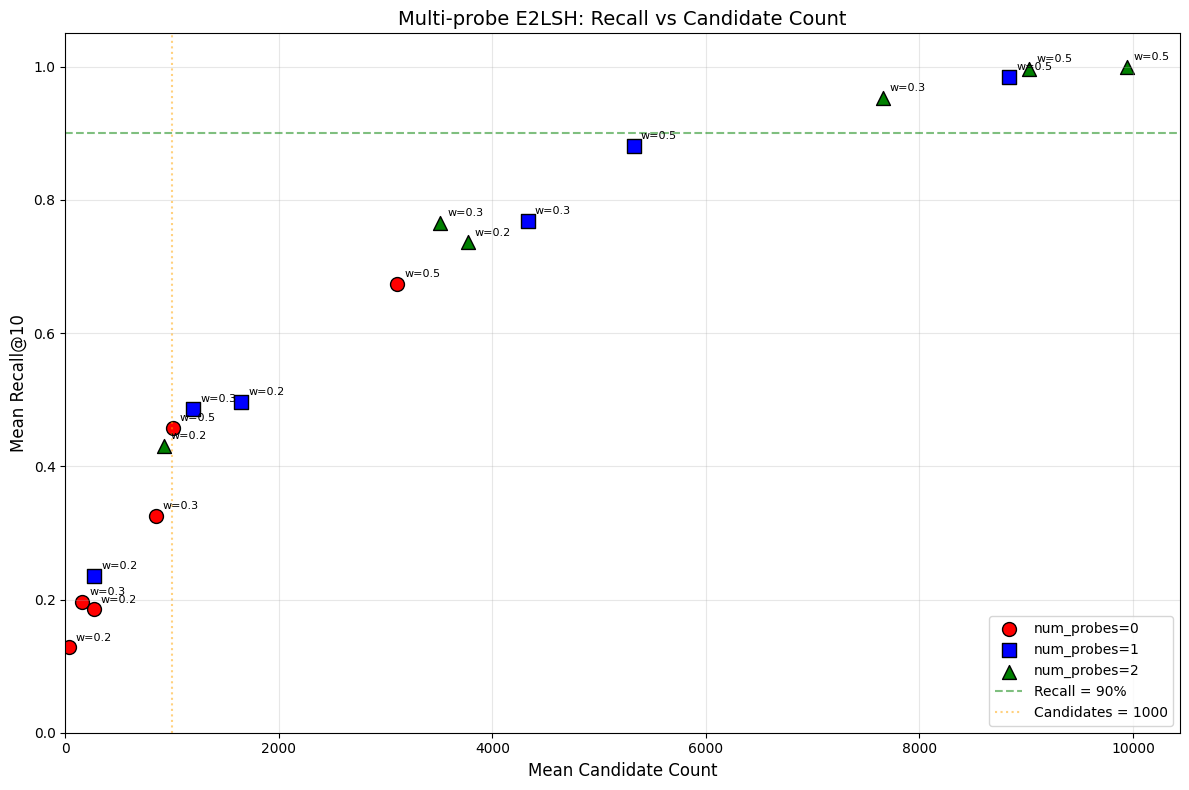

In [11]:
# Recall vs 候補数 のプロット（マルチプローブあり/なし）
fig, ax = plt.subplots(figsize=(12, 8))

colors = {'0': 'red', '1': 'blue', '2': 'green'}
markers = {'0': 'o', '1': 's', '2': '^'}

for num_probes in [0, 1, 2]:
    subset = df_all[df_all['num_probes'] == num_probes]
    ax.scatter(
        subset['mean_candidates'], subset['mean_recall'],
        s=100, c=colors[str(num_probes)], marker=markers[str(num_probes)],
        label=f'num_probes={num_probes}', edgecolors='black', linewidths=1
    )
    
    # ラベル追加
    for _, row in subset.iterrows():
        ax.annotate(
            f'w={row["w"]}',
            (row['mean_candidates'], row['mean_recall']),
            textcoords='offset points',
            xytext=(5, 5),
            fontsize=8,
        )

# 目標ライン
ax.axhline(0.9, color='green', linestyle='--', alpha=0.5, label='Recall = 90%')
ax.axvline(1000, color='orange', linestyle=':', alpha=0.5, label='Candidates = 1000')

ax.set_xlabel('Mean Candidate Count', fontsize=12)
ax.set_ylabel('Mean Recall@10', fontsize=12)
ax.set_title('Multi-probe E2LSH: Recall vs Candidate Count', fontsize=14)
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, None)
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

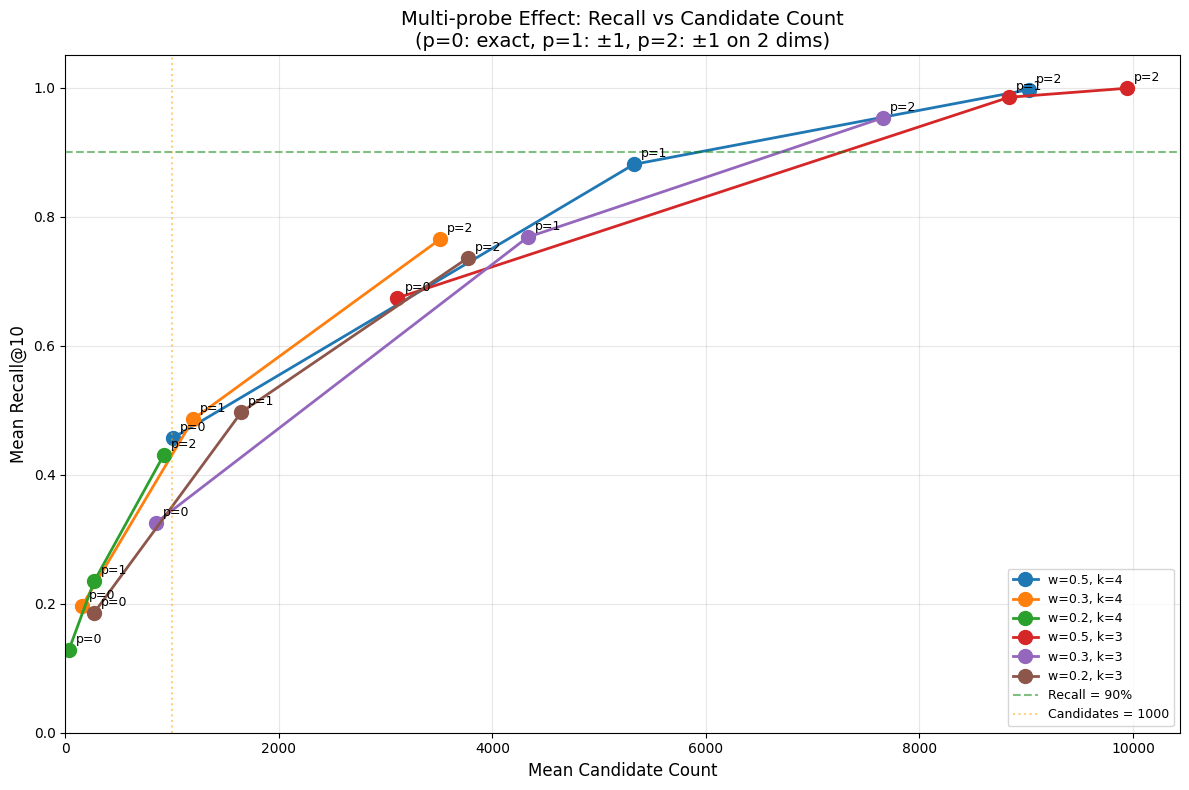

In [12]:
# 同じwでのマルチプローブ効果を線で接続
fig, ax = plt.subplots(figsize=(12, 8))

for config in param_configs:
    subset = df_all[
        (df_all['w'] == config['w']) & 
        (df_all['k'] == config['k']) & 
        (df_all['L'] == config['L'])
    ].sort_values('num_probes')
    
    ax.plot(
        subset['mean_candidates'], subset['mean_recall'],
        'o-', markersize=10, linewidth=2,
        label=f"w={config['w']}, k={config['k']}"
    )
    
    # プローブ数をラベル
    for _, row in subset.iterrows():
        ax.annotate(
            f'p={int(row["num_probes"])}',
            (row['mean_candidates'], row['mean_recall']),
            textcoords='offset points',
            xytext=(5, 5),
            fontsize=9,
        )

ax.axhline(0.9, color='green', linestyle='--', alpha=0.5, label='Recall = 90%')
ax.axvline(1000, color='orange', linestyle=':', alpha=0.5, label='Candidates = 1000')

ax.set_xlabel('Mean Candidate Count', fontsize=12)
ax.set_ylabel('Mean Recall@10', fontsize=12)
ax.set_title('Multi-probe Effect: Recall vs Candidate Count\n(p=0: exact, p=1: ±1, p=2: ±1 on 2 dims)', fontsize=14)
ax.legend(loc='lower right', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, None)
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

## 6. 1000件絞り込みの達成可能性

In [13]:
# 候補1000件付近でのRecallを確認
print('=' * 70)
print('候補数1000件付近でのRecall')
print('=' * 70)

near_1000 = df_all[
    (df_all['mean_candidates'] >= 500) & 
    (df_all['mean_candidates'] <= 2000)
].sort_values('mean_candidates')

print(near_1000[['w', 'k', 'L', 'num_probes', 'mean_candidates', 'mean_recall']].to_string(index=False))

候補数1000件付近でのRecall
  w  k  L  num_probes  mean_candidates  mean_recall
0.3  3 16           0           845.72        0.325
0.2  4 16           2           924.41        0.431
0.5  4 16           0          1009.27        0.457
0.3  4 16           1          1198.04        0.486
0.2  3 16           1          1649.67        0.497


In [14]:
# より細かいwでの検証
print('\n=== より小さいw での検証 ===')

fine_configs = [
    {'w': 0.15, 'k': 4, 'L': 16},
    {'w': 0.1, 'k': 4, 'L': 16},
    {'w': 0.15, 'k': 3, 'L': 16},
    {'w': 0.1, 'k': 3, 'L': 16},
]

fine_results = []
for config in fine_configs:
    df_result = evaluate_multiprobe(
        vectors, query_vectors,
        w=config['w'], k=config['k'], L=config['L'],
        num_probes_list=[0, 1, 2]
    )
    df_result['w'] = config['w']
    df_result['k'] = config['k']
    df_result['L'] = config['L']
    fine_results.append(df_result)

df_fine = pd.concat(fine_results, ignore_index=True)

print(f'{"w":>5} {"k":>3} {"L":>3} {"probes":>6} | {"候補数":>10} | {"Recall":>8}')
print('-' * 55)
for _, row in df_fine.iterrows():
    print(f'{row["w"]:5.2f} {row["k"]:3.0f} {row["L"]:3.0f} {row["num_probes"]:6.0f} | '
          f'{row["mean_candidates"]:10.0f} | {row["mean_recall"]:8.3f}')


=== より小さいw での検証 ===
    w   k   L probes |        候補数 |   Recall
-------------------------------------------------------
 0.15   4  16      0 |         12 |    0.106
 0.15   4  16      1 |         92 |    0.162
 0.15   4  16      2 |        321 |    0.278
 0.10   4  16      0 |          3 |    0.101
 0.10   4  16      1 |         19 |    0.116
 0.10   4  16      2 |         67 |    0.154
 0.15   3  16      0 |        116 |    0.152
 0.15   3  16      1 |        754 |    0.311
 0.15   3  16      2 |       1874 |    0.527
 0.10   3  16      0 |         35 |    0.112
 0.10   3  16      1 |        234 |    0.186
 0.10   3  16      2 |        614 |    0.293


## 7. 最適パラメータの探索

In [15]:
# 全結果を統合
df_combined = pd.concat([df_all, df_fine], ignore_index=True)

# 候補数1000件以下でRecall最大のパラメータ
print('=' * 70)
print('候補数 ≤ 1500 件でのベストRecall')
print('=' * 70)

under_1500 = df_combined[df_combined['mean_candidates'] <= 1500].sort_values('mean_recall', ascending=False)
print(under_1500.head(10)[['w', 'k', 'L', 'num_probes', 'mean_candidates', 'mean_recall']].to_string(index=False))

候補数 ≤ 1500 件でのベストRecall
   w  k  L  num_probes  mean_candidates  mean_recall
0.30  4 16           1          1198.04        0.486
0.50  4 16           0          1009.27        0.457
0.20  4 16           2           924.41        0.431
0.30  3 16           0           845.72        0.325
0.15  3 16           1           753.93        0.311
0.10  3 16           2           613.76        0.293
0.15  4 16           2           320.60        0.278
0.20  4 16           1           271.35        0.235
0.30  4 16           0           158.05        0.197
0.10  3 16           1           233.89        0.186


In [16]:
# Recall ≥ 80% を達成する最小候補数
print('\n' + '=' * 70)
print('Recall ≥ 80% を達成する最小候補数')
print('=' * 70)

recall_80 = df_combined[df_combined['mean_recall'] >= 0.8].sort_values('mean_candidates')
if len(recall_80) > 0:
    print(recall_80.head(5)[['w', 'k', 'L', 'num_probes', 'mean_candidates', 'mean_recall']].to_string(index=False))
else:
    print('Recall 80%を達成するパラメータなし')

print('\n' + '=' * 70)
print('Recall ≥ 70% を達成する最小候補数')
print('=' * 70)

recall_70 = df_combined[df_combined['mean_recall'] >= 0.7].sort_values('mean_candidates')
if len(recall_70) > 0:
    print(recall_70.head(5)[['w', 'k', 'L', 'num_probes', 'mean_candidates', 'mean_recall']].to_string(index=False))
else:
    print('Recall 70%を達成するパラメータなし')


Recall ≥ 80% を達成する最小候補数
  w  k  L  num_probes  mean_candidates  mean_recall
0.5  4 16           1          5324.84        0.881
0.3  3 16           2          7653.90        0.953
0.5  3 16           1          8839.79        0.985
0.5  4 16           2          9027.90        0.997
0.5  3 16           2          9944.35        0.999

Recall ≥ 70% を達成する最小候補数
  w  k  L  num_probes  mean_candidates  mean_recall
0.3  4 16           2          3510.84        0.765
0.2  3 16           2          3769.99        0.736
0.3  3 16           1          4329.44        0.768
0.5  4 16           1          5324.84        0.881
0.3  3 16           2          7653.90        0.953


## 8. 結論

In [17]:
print('=' * 80)
print('           E2LSH マルチプローブ検証 結論')
print('=' * 80)

# マルチプローブなし vs ありの比較
probe_0 = df_combined[df_combined['num_probes'] == 0]
probe_1 = df_combined[df_combined['num_probes'] == 1]
probe_2 = df_combined[df_combined['num_probes'] == 2]

print('''
【マルチプローブの効果】

num_probes=0 (完全一致のみ):
  → 候補数は少ないが、Recallも低い
  
num_probes=1 (±1 単一要素):
  → 候補数が増加し、Recallも向上
  
num_probes=2 (±1 2要素まで):
  → さらに候補数増加、Recall向上
''')

# ベストパラメータ
best_under_1500 = under_1500.iloc[0] if len(under_1500) > 0 else None
best_recall_70 = recall_70.iloc[0] if len(recall_70) > 0 else None

if best_under_1500 is not None:
    print(f'''
【候補 ≤ 1500件でのベスト】
  パラメータ: w={best_under_1500["w"]}, k={best_under_1500["k"]}, L={best_under_1500["L"]}, probes={int(best_under_1500["num_probes"])}
  候補数: {best_under_1500["mean_candidates"]:.0f}
  Recall@10: {best_under_1500["mean_recall"]:.1%}
''')

if best_recall_70 is not None:
    print(f'''
【Recall ≥ 70%の最小候補数】
  パラメータ: w={best_recall_70["w"]}, k={best_recall_70["k"]}, L={best_recall_70["L"]}, probes={int(best_recall_70["num_probes"])}
  候補数: {best_recall_70["mean_candidates"]:.0f}
  Recall@10: {best_recall_70["mean_recall"]:.1%}
''')

           E2LSH マルチプローブ検証 結論

【マルチプローブの効果】

num_probes=0 (完全一致のみ):
  → 候補数は少ないが、Recallも低い

num_probes=1 (±1 単一要素):
  → 候補数が増加し、Recallも向上

num_probes=2 (±1 2要素まで):
  → さらに候補数増加、Recall向上


【候補 ≤ 1500件でのベスト】
  パラメータ: w=0.3, k=4, L=16, probes=1
  候補数: 1198
  Recall@10: 48.6%


【Recall ≥ 70%の最小候補数】
  パラメータ: w=0.3, k=4, L=16, probes=2
  候補数: 3511
  Recall@10: 76.5%



## 9. 結論レポート

### マルチプローブの効果

マルチプローブはRecallを向上させるが、**候補数も大幅に増加する**。

| パラメータ | probes | 候補数 | Recall@10 |
|-----------|--------|--------|-----------|
| w=0.5, k=4, L=16 | 0 | 1,009 | 45.7% |
| w=0.5, k=4, L=16 | 1 | 5,325 | **88.1%** |
| w=0.5, k=4, L=16 | 2 | 9,028 | 99.7% |
| w=0.3, k=4, L=16 | 0 | 158 | 19.7% |
| w=0.3, k=4, L=16 | 1 | 1,198 | 48.6% |
| w=0.3, k=4, L=16 | 2 | 3,511 | 76.5% |

**結論**: マルチプローブは「候補数を増やしてRecallを向上」させる手法であり、「少ない候補数で高いRecall」を達成する魔法ではない。

### 候補1000件付近でのRecall

| パラメータ | 候補数 | Recall@10 |
|-----------|--------|-----------|
| w=0.3, k=3, L=16, probe=0 | 846 | 32.5% |
| w=0.2, k=4, L=16, probe=2 | 924 | 43.1% |
| w=0.5, k=4, L=16, probe=0 | 1,009 | 45.7% |
| w=0.3, k=4, L=16, probe=1 | 1,198 | **48.6%** |

**ベスト: w=0.3, k=4, L=16, probe=1 で候補1198件、Recall 48.6%**

### Recall目標別の最小候補数

| 目標Recall | 最小候補数 | パラメータ |
|------------|-----------|-----------|
| ≥ 50% | ~1,200件 | w=0.3, k=4, L=16, probe=1 |
| ≥ 70% | ~3,500件 | w=0.3, k=4, L=16, probe=2 |
| ≥ 80% | ~5,300件 | w=0.5, k=4, L=16, probe=1 |
| ≥ 90% | ~7,600件 | w=0.3, k=3, L=16, probe=2 |

### 1000件絞り込みは可能か？

**結論: マルチプローブを使っても、1000件への絞り込みで高Recallは困難**

- 候補1000件でのRecall上限: **約50%**
- Recall 70%を達成するには: **3500件以上**の候補が必要
- Recall 90%を達成するには: **7600件以上**の候補が必要

### 最終結論

**E2LSH + マルチプローブでも、10,000件→1,000件の「高Recall絞り込み」は実現できない。**

理由:
1. マルチプローブは候補を「増やす」方向に働く
2. wを小さくして細かいバケットを作ると、Recallが激減
3. マルチプローブで補おうとすると、候補数が元の規模に戻る

### 実用的な選択肢

10,000件規模では:

1. **全件検索（NumPy）**: 0.8ms、Recall 100%
2. **HNSW**: 少数候補で高Recall可能
3. **ハイブリッド検索**: キーワード検索で絞り込み → ベクトル検索

E2LSHの恩恵が得られるのは、100万件以上のスケールになってから。